In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import gridspec
from scipy.spatial.distance import cdist

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Restore pre-trained Convnet model

In [2]:
sess = tf.Session()

In [3]:
saver =  tf.train.import_meta_graph('./tmp/minst_convnet_model.ckpt.meta')
saver.restore(sess, tf.train.latest_checkpoint('./tmp/'))

INFO:tensorflow:Restoring parameters from ./tmp/minst_convnet_model.ckpt


### Retrieve tensors 

In [5]:
training = sess.graph.get_tensor_by_name('training:0')
x = sess.graph.get_tensor_by_name('Placeholder:0')
y = sess.graph.get_tensor_by_name('Placeholder_1:0')
fc1_relu = sess.graph.get_tensor_by_name('fc1/Relu:0')
logit = sess.graph.get_tensor_by_name('logits/BiasAdd:0')

### Compute fc1 layer embedding features for MNIST test images

In [6]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
X = mnist.test.images  # Returns np.array
Y = np.asarray(mnist.test.labels, dtype=np.int32)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [7]:
X_fc1_embedding = sess.run(fc1_relu, feed_dict={x: X, training: False})
X_fc1_embedding.shape

(10000, 1024)

In [8]:
X_logit_embedding = sess.run(logit, feed_dict={x: X, training: False})
X_logit_embedding.shape

(10000, 10)

In [9]:
sess.close()

### Utility Functions

In [10]:
images_data = np.reshape(X, [-1,28,28,1])

In [11]:
def display_images(idxs):
    try:
        n = len(idxs)
    except TypeError:
        idxs = [idxs]
        n = 1    
    rows = n // 10 + (1 if n % 10 > 0 else 0)
    cols = min(n, 10)
    scale = 2.5
    fig = plt.figure(figsize=(cols * 0.6 * scale, rows * 0.45 * scale))
    gs = gridspec.GridSpec(rows, cols)
    gs.update(wspace=0.05)
    for i in range(n):
        r, c = i // 10, i % 10
        ax = fig.add_subplot(gs[r,c])
        ax.imshow(images_data[idxs[i],:,:,0])
        ax.axis('off')
    plt.show()

In [34]:
def retrieve_similar_images(features, query_idx, k=10, dist_metric='euclidean'):    
    dist = cdist(features[query_idx].reshape(1,-1), features, dist_metric)
    rank = np.argsort(dist[0])
    rank_top_k = rank[1:k+1]
    prec = sum(1 if Y[query_idx] == Y[idx] else 0 for idx in rank_top_k) / k
    print('precision = %f' % prec)
    print('top %d idxs = %s' % (k, rank_top_k))    
    display_images(rank_top_k)

## Display some examples

============ Example 1 ===================

query: idx = 9024


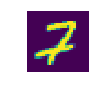

------------ similar images - FC1 embedding - euclidean metric -------------
precision = 0.520000
top 25 idxs = [9036 9009 9019 5127 3767 9031 2628 4504 5120 2016 9044 1283 9045 8208
 9623 7154 5820 1349 2820 7151 2507 7483 3349 7486  888]


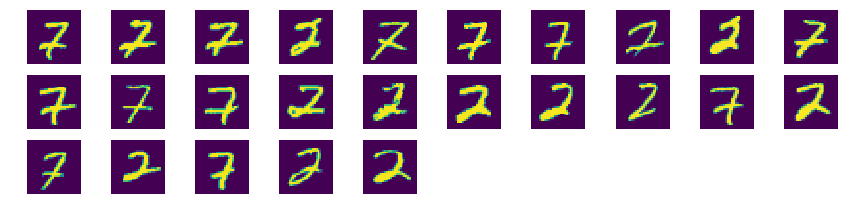

------------ similar images - LOGIT embedding - euclidean metric -------------
precision = 0.920000
top 25 idxs = [9009 9036 3767 2016 9019 1143 4566 3329  583 9015 4658  898 4225 2820
 2325 1903 1933 2841 2665 8282 3848 5127 9044 2547 1091]


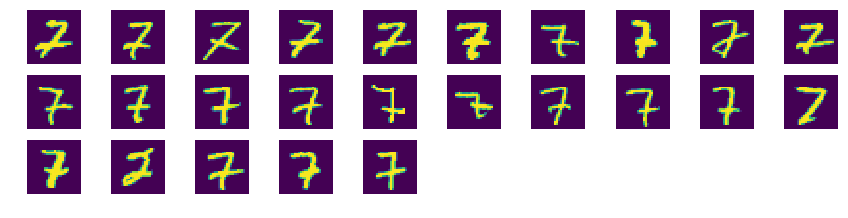

============ Example 2 ===================

query: idx = 9740


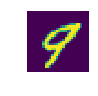

------------ similar images - FC1 embedding - euclidean metric -------------
precision = 1.000000
top 25 idxs = [9252 9741 9767 7136 5106 9255 6747 5135 9723 7243 9544 5100 4570 6967
 9973 9924 9214 7874 7580 7148 6793 4786 5009 6718 9713]


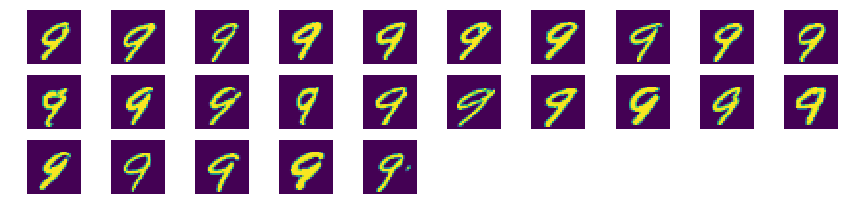

------------ similar images - LOGIT embedding - euclidean metric -------------
precision = 1.000000
top 25 idxs = [9767 7071 9544 4963  874 5262  417 6967   12 9843 9924 6747 9252 4047
 7496 8846 9362 9562 5135 9386 7095 7107 1063 2854 9357]


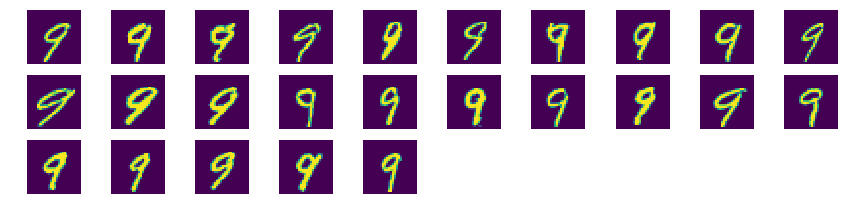

============ Example 3 ===================

query: idx = 1272


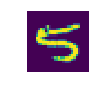

------------ similar images - FC1 embedding - euclidean metric -------------
precision = 1.000000
top 25 idxs = [2773  791 3750 3763 9382 3022 3416 3145 9493 9085 1421 2134 2476 4094
 1948 2697 1510 2247  778 2030 1221 6146 9133   53 9176]


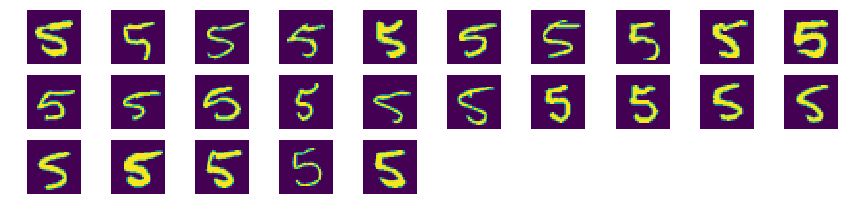

------------ similar images - LOGIT embedding - euclidean metric -------------
precision = 1.000000
top 25 idxs = [ 791 4056  951 2445  218 1761 2773  460   59 3336 6909 3311 4712 9290
 6530 5174 3145 3117 3623 6042 9493 3763 1510 2134 9382]


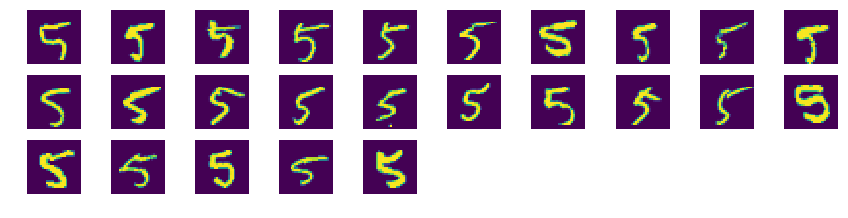

============ Example 4 ===================

query: idx = 7482


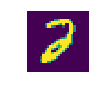

------------ similar images - FC1 embedding - euclidean metric -------------
precision = 1.000000
top 25 idxs = [7486  875 4189 3628 4342 1349 3415 5820 4684 4401  199 1002 7457 6217
 4167 9521 9849 2848 2248  418 4559 1395 6773  225 7348]


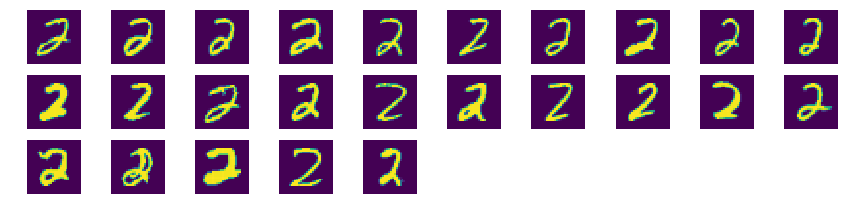

------------ similar images - LOGIT embedding - euclidean metric -------------
precision = 1.000000
top 25 idxs = [7486 4939 4342 1839  225 3628 4167 9874 1915 2248 2242 1056 4189 2058
 9855 9893 9867 7348 2374 5626  321 2481 3260 9849 9847]


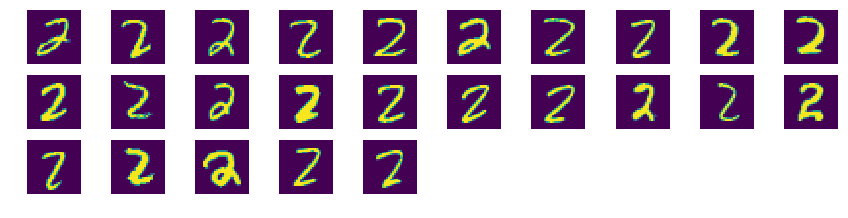

In [35]:
dist_metric = 'euclidean'
for i, idx in enumerate((9024,9740,1272,7482)):
    print('==========================================')
    print('============ Example %d ===================' % (i+1))
    print('==========================================\n')
    print('query: idx = %d' % idx)
    display_images(idx)
    print('------------ similar images - FC1 embedding - %s metric -------------' % dist_metric)
    retrieve_similar_images(X_fc1_embedding, query_idx=idx, k = 25, dist_metric=dist_metric)
    print('------------ similar images - LOGIT embedding - %s metric -------------' % dist_metric)
    retrieve_similar_images(X_logit_embedding, query_idx=idx, k = 25, dist_metric=dist_metric)